- Make our models interpretable. We’ll show which words/tokens push predictions toward fake vs genuine, both globally and per-review.

Models explained:

  - TF-IDF + Logistic Regression (transparent linear model → easy to see n-gram weights)

   - DistilBERT (contextual model → token importances via Integrated Gradients)

Artifacts used:

models/sp_tfidf_vectorizer.joblib

models/sp_logreg.joblib (or adjust name if yours differs)

models/distilbert_mix_from_splits_10k/ (HF checkpoint folder)

In [1]:
## Setup

!pip -q install transformers==4.54.0 captum==0.7.0 datasets==2.20.0 matplotlib scikit-learn lime

import os, re, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import display, HTML

# Matplotlib defaults
plt.rcParams["figure.dpi"] = 130
plt.rcParams["axes.grid"] = True


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 833.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.9 MB/s eta 0:00:00


## 1) Load models and validation set

In [2]:
import joblib, glob
from sklearn.metrics import classification_report, confusion_matrix

# --- Paths (edit if needed) ---
LR_PATHS = {
    "vec": "models/sp_tfidf_vectorizer.joblib",
    "clf":  "models/sp_logreg.joblib",            # rename if you saved differently
}
BERT_DIR = "models/distilbert_mix_from_splits_10k"  # your fine-tuned checkpoint
VAL_PATH = "project_splits/sp_val.csv"              # optional; falls back to mini sample

# --- Load LR artifacts ---
vec = joblib.load(LR_PATHS["vec"])
clf = joblib.load(LR_PATHS["clf"])

# --- Load DistilBERT artifacts ---
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(BERT_DIR)
bert = AutoModelForSequenceClassification.from_pretrained(BERT_DIR)
bert.eval();

# --- Load some data (SP task labels: 0=fake, 1=genuine) ---
if os.path.exists(VAL_PATH):
    df_val = pd.read_csv(VAL_PATH)
    # Expecting columns like: ["Text","Score","label"] after your preprocessing/splits
    text_col = "Text" if "Text" in df_val.columns else "text"
    label_col = "label" if "label" in df_val.columns else "Label"
    texts = df_val[text_col].astype(str).tolist()[:2000]  # cap to keep demos fast
    labels = df_val[label_col].astype(int).tolist()[:2000]
else:
    # Tiny fallback set
    texts = [
        "I got this for free; honestly the aftertaste was gross and soggy texture.",
        "Amazing cookies! Fresh, crispy, would buy again.",
        "Received yesterday and loved it. Great flavor and quick shipping.",
        "Tastes like cardboard. Very disappointed."
    ]
    labels = [0, 1, 1, 0]  # pretend ground truth for demo
len(texts), texts[:2]


(4,
 ['I got this for free; honestly the aftertaste was gross and soggy texture.',
  'Amazing cookies! Fresh, crispy, would buy again.'])

## 2) Global explainability — TF-IDF + Logistic Regression

### 2.1 Top weighted n-grams (global)

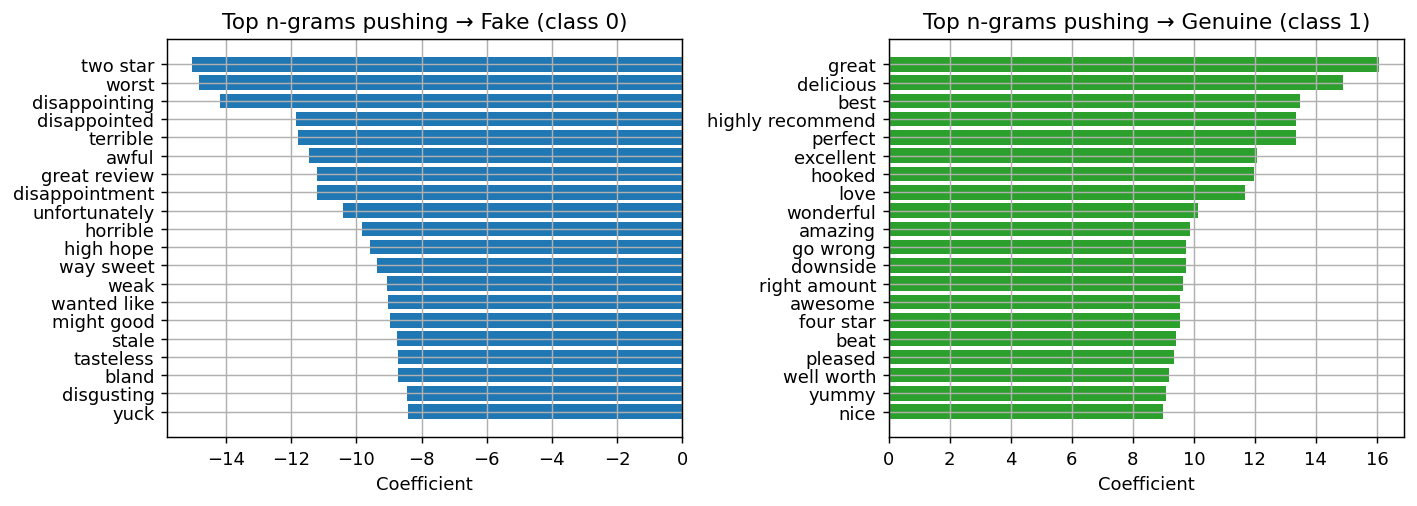

In [3]:
# Pull feature names aligned to classifier coefficients
feature_names = np.array(vec.get_feature_names_out())
coefs = clf.coef_[0]  # binary: shape (n_features,)

def plot_top_features(coefs, feature_names, top_k=20):
    idx_pos = np.argsort(coefs)[-top_k:][::-1]   # towards class 1 (genuine)
    idx_neg = np.argsort(coefs)[:top_k]          # towards class 0 (fake)

    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    ax[0].barh(feature_names[idx_neg][::-1], coefs[idx_neg][::-1])
    ax[0].set_title("Top n-grams pushing → Fake (class 0)")
    ax[0].set_xlabel("Coefficient")

    ax[1].barh(feature_names[idx_pos][::-1], coefs[idx_pos][::-1], color="tab:green")
    ax[1].set_title("Top n-grams pushing → Genuine (class 1)")
    ax[1].set_xlabel("Coefficient")
    plt.tight_layout(); plt.show()

plot_top_features(coefs, feature_names, top_k=20)


## 3) Local explainability — TF-IDF + Logistic Regression (per review)
We compute per-review contributions: contribution = tfidf_value * coefficient for the n-grams present.

'I got this for free; honestly the aftertaste was gross and soggy texture.'

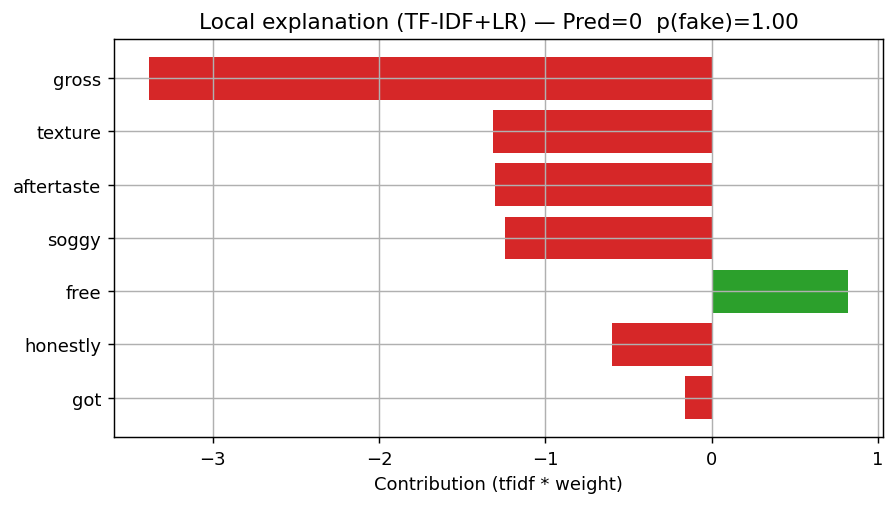

,token,contribution
0,gross,-3.385319
1,texture,-1.314831
2,aftertaste,-1.305178
3,soggy,-1.244471
4,free,0.819649
5,honestly,-0.601852
6,got,-0.162421


In [4]:
from scipy.sparse import csr_matrix

def explain_logreg_local(text, top_k=10):
    X = vec.transform([text])            # 1 x V sparse
    logits = clf.decision_function(X)[0]
    proba = clf.predict_proba(X)[0]      # [p(fake), p(genuine)]
    pred = int(proba.argmax())

    # get indices of non-zero features
    X_csr = csr_matrix(X)
    nz_idx = X_csr.nonzero()[1]
    vals = X_csr.data

    # contributions
    contribs = vals * coefs[nz_idx]
    toks = feature_names[nz_idx]

    # sort by absolute impact
    order = np.argsort(np.abs(contribs))[::-1]
    toks, contribs = toks[order], contribs[order]

    # plot
    k = min(top_k, len(toks))
    colors = ["tab:green" if c>0 else "tab:red" for c in contribs[:k]]
    plt.figure(figsize=(7,4))
    plt.barh(toks[:k][::-1], contribs[:k][::-1], color=colors[::-1])
    plt.title(f"Local explanation (TF-IDF+LR) — Pred={pred}  p(fake)={proba[0]:.2f}")
    plt.xlabel("Contribution (tfidf * weight)")
    plt.tight_layout(); plt.show()

    # return details as a table
    return pd.DataFrame({"token": toks[:k], "contribution": contribs[:k]})

# Try on a review:
row = 0
display(texts[row])
explain_logreg_local(texts[row], top_k=15)


## 4) Local explainability — DistilBERT with Integrated Gradients (Captum)
We attribute the class logit to each input token.

In [12]:
import torch
import numpy as np
from captum.attr import LayerIntegratedGradients
from IPython.display import HTML, display

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
bert.to(DEVICE)
bert.eval()

def bert_token_attributions(text, target=0, n_steps=24, max_len=64):
    """
    Returns (tokens, normalized_scores, attention_mask) for a single text.
    target=0 -> 'fake', target=1 -> 'genuine' (your SP setup).
    """
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=max_len,
    )
    input_ids = enc["input_ids"].to(DEVICE)
    attention_mask = enc["attention_mask"].to(DEVICE)

    # forward function that uses input_ids (so embeddings layer is used)
    def forward_ids(ids, attn_mask):
        out = bert(input_ids=ids, attention_mask=attn_mask)
        # return the logit for the target class
        return out.logits[:, target]

    lig = LayerIntegratedGradients(forward_ids, bert.distilbert.embeddings)

    bert.zero_grad()
    attributions = lig.attribute(
        inputs=input_ids,
        additional_forward_args=(attention_mask,),
        n_steps=n_steps,
    )
    # shape: [1, seq_len, hidden_size] –> sum over hidden to get per-token score
    token_attr = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()

    # normalize for display
    token_attr = token_attr / (np.abs(token_attr).max() + 1e-8)

    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0))
    return tokens, token_attr, attention_mask.squeeze(0).cpu().numpy()

def show_token_heatmap(tokens, scores, attn_mask, title="Token attributions"):
    keep = np.where(attn_mask == 1)[0]  # drop [PAD]
    toks  = [t for i, t in enumerate(tokens) if i in keep]
    scs   = [float(s) for i, s in enumerate(scores) if i in keep]

    def color(v):
        # green = pushes toward target class; red = pushes away
        a = min(1.0, abs(v))
        return (f"background-color: rgba(0,200,0,{a:.2f});" if v >= 0
                else f"background-color: rgba(220,0,0,{a:.2f});")

    html = ["<div style='font-family:monospace; line-height:2'>",
            f"<b>{title}</b><br/>"]
    for t, s in zip(toks, scs):
        html.append(f"<span style='padding:2px 4px; margin:2px; {color(s)}'>{t}</span>")
    html.append("</div>")
    display(HTML("".join(html)))


# Example on one review for target class "fake" (0)
row = 0  # pick a review
tokens, scores, mask = bert_token_attributions(
    texts[row], target=0, n_steps=24, max_len=64
)
show_token_heatmap(tokens, scores, mask, title="DistilBERT IG → class 'fake' (0)")


## 5) Quick metrics

In [13]:
# LR on current texts
X = vec.transform(texts)
pred_lr = clf.predict(X)
print("LogReg\n", classification_report(labels, pred_lr, digits=3))

# DistilBERT on current texts
def bert_predict(batch_texts, max_len=64):
    all_probs = []
    with torch.no_grad():
        for t in batch_texts:
            enc = tokenizer(t, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
            out = bert(**{k:v.to(DEVICE) for k,v in enc.items()})
            probs = out.logits.softmax(-1).cpu().numpy().squeeze()
            all_probs.append(probs)
    preds = np.argmax(np.vstack(all_probs), axis=1)
    return preds

pred_bert = bert_predict(texts)
print("DistilBERT\n", classification_report(labels, pred_bert, digits=3))


LogReg
               precision    recall  f1-score   support

           0      1.000     1.000     1.000         2
           1      1.000     1.000     1.000         2

    accuracy                          1.000         4
   macro avg      1.000     1.000     1.000         4
weighted avg      1.000     1.000     1.000         4

DistilBERT
               precision    recall  f1-score   support

           0      1.000     1.000     1.000         2
           1      1.000     1.000     1.000         2

    accuracy                          1.000         4
   macro avg      1.000     1.000     1.000         4
weighted avg      1.000     1.000     1.000         4



## 6) Side-by-side local rationale (same review)

REVIEW:
 I got this for free; honestly the aftertaste was gross and soggy texture.


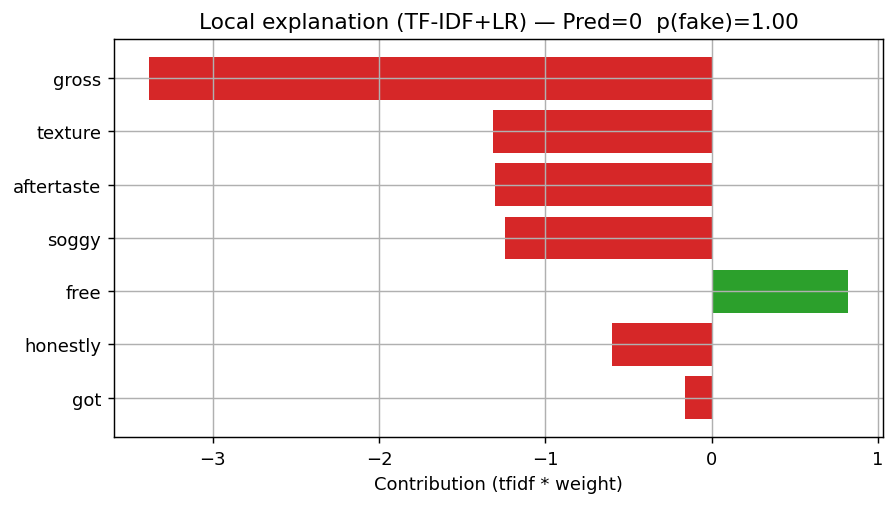

In [14]:
review = texts[0]
print("REVIEW:\n", review)

# LR contributions
df_local = explain_logreg_local(review, top_k=12)

# BERT heatmap toward 'fake'
tokens, scores, mask = bert_token_attributions(review, target=0, n_steps=24, max_len=64)
show_token_heatmap(tokens, scores, mask, title="DistilBERT: token attributions → fake")


## LIME for sanity (LogReg)

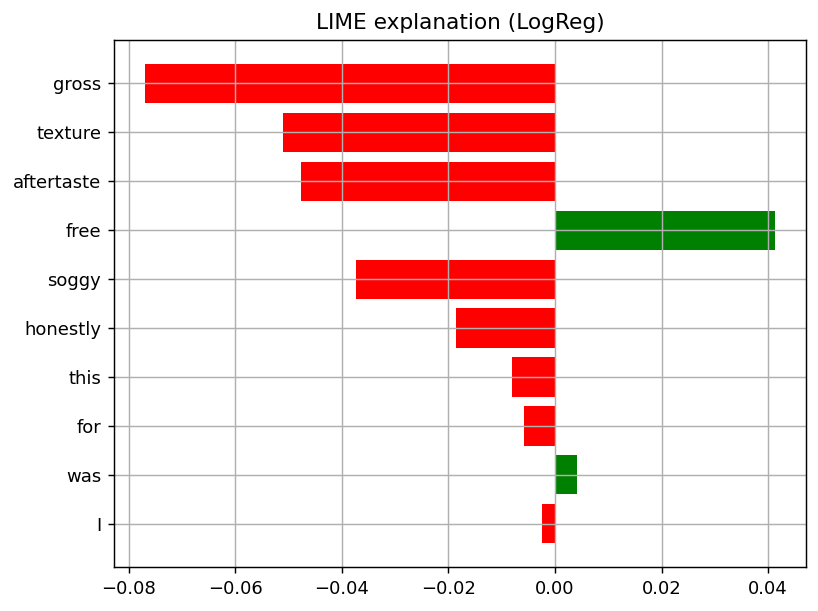

In [15]:
from lime.lime_text import LimeTextExplainer

class_names = ["fake","genuine"]
explainer = LimeTextExplainer(class_names=class_names)

def lr_predict_proba(text_list):
    X = vec.transform(text_list)
    return clf.predict_proba(X)

exp = explainer.explain_instance(review, lr_predict_proba, num_features=10)
fig = exp.as_pyplot_figure()
plt.title("LIME explanation (LogReg)")
plt.tight_layout(); plt.show()


## 8) Save plots

<Figure size 832x624 with 0 Axes>

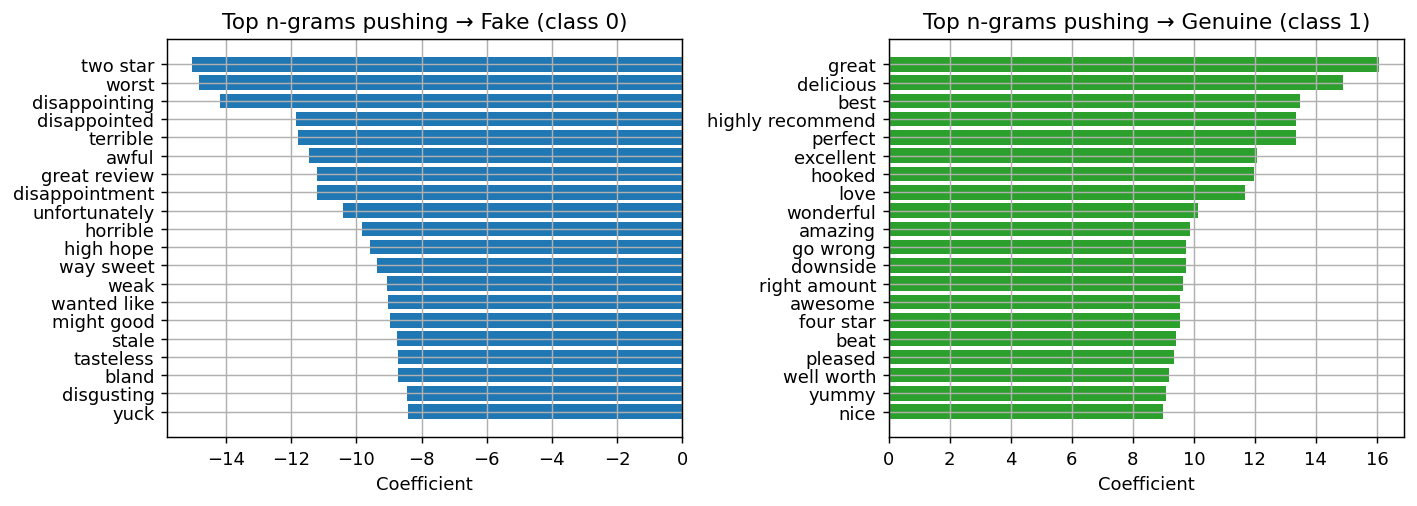

Saved plots in ./plots/


<Figure size 832x624 with 0 Axes>

In [16]:
os.makedirs("plots", exist_ok=True)
plt.figure()
plot_top_features(coefs, feature_names, top_k=20)
plt.savefig("plots/lr_global_top_features.png", bbox_inches="tight", dpi=160)
print("Saved plots in ./plots/")
